In [2]:
# SpaceXplorers_final_cleaning.py / cell in SpaceXplorers_notebook_cleaning.ipynb
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime

# ---------- Config ----------
INPUT = "train.csv"
OUTPUT_CLEAN = "cleaned_dataset.csv"
OUTPUT_NORM = "normalized_train.csv"
CLEAN_LOG = "cleaning_log.csv"
IMPUTE_LOG = "imputation_log.csv"
REPORT_TXT = "cleaning_report.txt"

SPENDING_COLS_CANDIDATES = [
    "roomservice", "room_service",
    "foodcourt", "food_court",
    "shoppingmall", "shopping_mall",
    "spa",
    "vrdeck", "vr_deck",
    "total_spend", "total_expenditure"
]

BOOL_LIKE = ["cryosleep", "vip", "transported"]

# ---------- Helpers ----------
def ensure_lower_cols(df):
    df.columns = [c.strip() for c in df.columns]
    return df

def detect_id_column(df):
    candidates = ["passengerid", "passenger_id", "id", "passenger"]
    cols_lower = [c.lower() for c in df.columns]
    for cand in candidates:
        if cand in cols_lower:
            return df.columns[cols_lower.index(cand)]
    # fallback: look for pattern like '0001_01'
    for c in df.columns:
        if df[c].astype(str).str.match(r'^\d{4}_\d{2}$').any():
            return c
    return None

def parse_cabin(c):
    # Expect format like 'B/201/P' or 'F/1/S'; return deck,num,side or (None,None,None)
    try:
        if pd.isna(c):
            return None, None, None
        s = str(c).strip()
        parts = s.split('/')
        if len(parts) >= 3:
            deck = parts[0]
            num = parts[1]
            side = parts[2]
            return deck, num, side
        return None, None, None
    except Exception:
        return None, None, None

def safe_median(series):
    series = pd.to_numeric(series, errors='coerce')
    if series.notna().sum() == 0:
        return 0
    return series.median()

# ---------- Load ----------
if not os.path.exists(INPUT):
    raise FileNotFoundError(f"{INPUT} not found. Place train.csv next to this notebook.")

raw = pd.read_csv(INPUT, dtype=object)  # load as object to avoid surprises
raw_cols = raw.columns.tolist()

df = raw.copy(deep=True)
df = ensure_lower_cols(df)

# Detect id column and standardize column names
id_col = detect_id_column(df)
if id_col is None:
    raise ValueError("Passenger ID column not found. Ensure a column like PassengerId exists.")
# unify to 'passengerid' for internal use
if id_col != 'passengerid':
    df.rename(columns={id_col: 'passengerid'}, inplace=True)
    id_col = 'passengerid'

# Standardize other column names (lowercase, underscores)
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# ---------- Step 0: Must-have checks ----------
initial_rows = df.shape[0]

# Drop rows missing passengerid (essential key)
missing_id_mask = df['passengerid'].isnull() | (df['passengerid'].astype(str).str.strip() == "")
if missing_id_mask.any():
    dropped_ids = df.loc[missing_id_mask, 'passengerid'].tolist()
    df = df.loc[~missing_id_mask].reset_index(drop=True)
else:
    dropped_ids = []

# ---------- Derive family and surname ----------
# family prefix from passengerid like '0001' from '0001_01'
df['family_prefix'] = df['passengerid'].astype(str).str.split('_').str[0]

# surname: take last token of name if available
if 'name' in df.columns:
    df['surname'] = df['name'].astype(str).str.strip().replace('nan', np.nan)
    df['surname'] = df['surname'].where(df['surname'].notnull(), None)
    df['surname_extracted'] = df['surname'].apply(lambda x: str(x).split()[-1].lower() if pd.notna(x) else None)
else:
    df['name'] = None
    df['surname_extracted'] = None

# ---------- normalize booleans like cryosleep/vip/transported ----------
for b in BOOL_LIKE:
    if b in df.columns:
        df[b] = df[b].astype(str).str.strip().str.lower().map({
            'true': True, 't': True, '1': True,
            'false': False, 'f': False, '0': False
        })
        df[b] = df[b].where(df[b].isin([True, False]), np.nan)

# ---------- Identify numeric columns (safe coercion) ----------
numeric_cols = []
for c in df.columns:
    if c == 'passengerid' or c in ['name', 'cabin', 'surname', 'surname_extracted', 'family_prefix']:
        continue
    coerced = pd.to_numeric(df[c], errors='coerce')
    # if reasonable fraction is numeric, treat as numeric
    if coerced.notna().sum() >= max(5, 0.5 * len(coerced)):
        df[c] = coerced
        numeric_cols.append(c)
    else:
        # keep as categorical/string
        df[c] = df[c].astype(object)

# ---------- Parse cabin into deck/number/side ----------
df['deck'] = None
df['cabin_number'] = None
df['side'] = None
if 'cabin' in df.columns:
    parsed = df['cabin'].apply(lambda x: parse_cabin(x))
    df['deck'] = parsed.apply(lambda t: t[0])
    df['cabin_number'] = parsed.apply(lambda t: t[1])
    df['side'] = parsed.apply(lambda t: t[2])

# ---------- Cleaning log structure ----------
log = {
    'initial_rows': initial_rows,
    'rows_dropped_missing_id': len(dropped_ids),
    'dropped_ids_sample': dropped_ids[:10],
    'duplicates_removed': 0,
    'missing_before': int(df.isnull().sum().sum()),
    'missing_after': None,
    'imputations': [],
    'clipped_cells': 0,
    'normalized_columns': [],
    'timestamp': datetime.datetime.utcnow().isoformat() + "Z"
}

# ---------- Remove exact duplicate rows (keep first) ----------
dup_mask = df.duplicated(keep='first')
dup_count = int(dup_mask.sum())
dup_ids_removed = []
if dup_count > 0:
    dup_ids_removed = df.loc[dup_mask, 'passengerid'].tolist()
    df = df.loc[~dup_mask].reset_index(drop=True)
log['duplicates_removed'] = dup_count
log['duplicate_ids_removed_sample'] = dup_ids_removed[:10]

# ---------- Impute HomePlanet ----------
# Strategy: family mode -> cabin deck majority -> destination mode -> "Unknown"
if 'homeplanet' in df.columns:
    for idx, row in df[df['homeplanet'].isnull()].iterrows():
        fam = row['family_prefix']
        fam_mode = df.loc[df['family_prefix']==fam, 'homeplanet'].mode(dropna=True)
        if not fam_mode.empty:
            df.at[idx, 'homeplanet'] = fam_mode.iloc[0]
            log['imputations'].append({'column':'homeplanet','method':'family_mode','row':row['passengerid']})
            continue
        # cabin deck majority
        if pd.notna(row.get('deck')):
            deck = row['deck']
            deck_mode = df.loc[df['deck']==deck, 'homeplanet'].mode(dropna=True)
            if not deck_mode.empty:
                df.at[idx, 'homeplanet'] = deck_mode.iloc[0]
                log['imputations'].append({'column':'homeplanet','method':'deck_mode','row':row['passengerid']})
                continue
        # destination mode
        if 'destination' in df.columns and pd.notna(row.get('destination')):
            dest_mode = df.loc[df['destination']==row['destination'], 'homeplanet'].mode(dropna=True)
            if not dest_mode.empty:
                df.at[idx, 'homeplanet'] = dest_mode.iloc[0]
                log['imputations'].append({'column':'homeplanet','method':'destination_mode','row':row['passengerid']})
                continue
        # fallback
        df.at[idx, 'homeplanet'] = 'Unknown'
        log['imputations'].append({'column':'homeplanet','method':'fallback_unknown','row':row['passengerid']})

# ---------- Impute CryoSleep ----------
# Strategy: if cryosleep missing, infer True if all spending columns zero or family majority says True
spending_cols_present = [c for c in SPENDING_COLS_CANDIDATES if c in df.columns]

# Create cryosleep column if it doesn't exist (before imputation logic)
if 'cryosleep' not in df.columns:
    df['cryosleep'] = np.nan

for idx, row in df[df['cryosleep'].isnull()].iterrows():
    # family majority
    fam = row['family_prefix']
    fam_mode = df.loc[df['family_prefix']==fam, 'cryosleep'].mode(dropna=True)
    if not fam_mode.empty:
        val = fam_mode.iloc[0]
        df.at[idx, 'cryosleep'] = val
        log['imputations'].append({'column':'cryosleep','method':'family_mode','row':row['passengerid']})
        continue
    # if spending columns exist and all zero or missing => cryosleep True
    if spending_cols_present:
        spends = row[spending_cols_present].astype(float).fillna(0)
        if (spends <= 0).all():
            df.at[idx, 'cryosleep'] = True
            log['imputations'].append({'column':'cryosleep','method':'spend_zero_rule','row':row['passengerid']})
            continue
    # fallback: False
    df.at[idx, 'cryosleep'] = False
    log['imputations'].append({'column':'cryosleep','method':'fallback_false','row':row['passengerid']})

# Fill any remaining NaN values in cryosleep with False
df['cryosleep'] = df['cryosleep'].fillna(False)

# ---------- Impute Cabin (deck/number/side) ----------
# If cabin missing, fill from family majority cabin if available, else leave NaN
if 'cabin' in df.columns:
    missing_cab = df['cabin'].isnull()
    for idx in df[missing_cab].index:
        fam = df.at[idx, 'family_prefix']
        fam_cabmode = df.loc[df['family_prefix']==fam, 'cabin'].mode(dropna=True)
        if not fam_cabmode.empty:
            df.at[idx, 'cabin'] = fam_cabmode.iloc[0]
            deck,num,side = parse_cabin(fam_cabmode.iloc[0])
            df.at[idx, 'deck'] = deck
            df.at[idx, 'cabin_number'] = num
            df.at[idx, 'side'] = side
            log['imputations'].append({'column':'cabin','method':'family_mode','row':df.at[idx,'passengerid']})

# ---------- Impute Destination ----------
if 'destination' in df.columns:
    for idx, row in df[df['destination'].isnull()].iterrows():
        fam = row['family_prefix']
        fam_mode = df.loc[df['family_prefix']==fam, 'destination'].mode(dropna=True)
        if not fam_mode.empty:
            df.at[idx, 'destination'] = fam_mode.iloc[0]
            log['imputations'].append({'column':'destination','method':'family_mode','row':row['passengerid']})
            continue
        # fallback: use mode for same homeplanet
        if pd.notna(row.get('homeplanet')):
            hp_mode = df.loc[df['homeplanet']==row['homeplanet'], 'destination'].mode(dropna=True)
            if not hp_mode.empty:
                df.at[idx, 'destination'] = hp_mode.iloc[0]
                log['imputations'].append({'column':'destination','method':'homeplanet_mode','row':row['passengerid']})
                continue
        df.at[idx, 'destination'] = 'Unknown'
        log['imputations'].append({'column':'destination','method':'fallback_unknown','row':row['passengerid']})

# ---------- Impute Age ----------
# strategy: median grouped by cryosleep and homeplanet (if available), else global median
age_col = 'age' if 'age' in df.columns else None
if age_col:
    for idx, row in df[df[age_col].isnull()].iterrows():
        grp = df[(df['cryosleep'] == row['cryosleep']) & (df['homeplanet'] == row['homeplanet'])]
        med = safe_median(grp[age_col]) if not grp.empty else np.nan
        if np.isnan(med) or med == 0:
            med = safe_median(df[age_col])  # fallback
        df.at[idx, age_col] = med
        log['imputations'].append({'column':'age','method':'group_median','row':row['passengerid']})

# Ensure age non-negative numeric; if negatives replace with median
if age_col:
    df[age_col] = pd.to_numeric(df[age_col], errors='coerce')
    neg_mask = df[age_col] < 0
    if neg_mask.any():
        med = safe_median(df[age_col][~neg_mask])
        df.loc[neg_mask, age_col] = med
        log['imputations'].append({'column':'age','method':'negatives_replaced_by_median','count':int(neg_mask.sum())})

# ---------- VIP imputation ----------
if 'vip' in df.columns:
    df['vip'] = df['vip'].fillna(False)
else:
    df['vip'] = False

# ---------- Name handling ----------
if 'name' in df.columns:
    missing_names = df['name'].isnull().sum()
    # fill with placeholder using passengerid (non-destructive)
    df['name'] = df['name'].fillna(df['passengerid'].apply(lambda x: f"Unknown_{x}"))
    if missing_names > 0:
        log['imputations'].append({'column':'name','method':'fill_with_id_placeholder','filled': int(missing_names)})
else:
    df['name'] = df['passengerid'].apply(lambda x: f"Unknown_{x}")
    log['imputations'].append({'column':'name','method':'created_from_id','filled': df.shape[0]})

# ---------- Spending columns handling ----------
spend_cols = [c for c in SPENDING_COLS_CANDIDATES if c in df.columns]
# fallback: detect numeric columns that look continuous and likely spendings
if not spend_cols:
    for c in numeric_cols:
        if c in ['age']:  # ignore age
            continue
        if df[c].nunique(dropna=True) > 10:
            spend_cols.append(c)
# dedupe
spend_cols = list(dict.fromkeys(spend_cols))

# If cryosleep True => spending = 0 for those rows
if spend_cols:
    for sc in spend_cols:
        df[sc] = pd.to_numeric(df[sc], errors='coerce')
    # set spending to zero for cryosleep passengers
    cryo_mask = df['cryosleep'] == True
    for sc in spend_cols:
        df.loc[cryo_mask, sc] = 0.0

    # Impute spendings for non-cryo rows using family median -> homeplanet median -> global median
    for sc in spend_cols:
        for idx, row in df[df[sc].isnull() & (df['cryosleep'] != True)].iterrows():
            fam = row['family_prefix']
            fam_med = df.loc[(df['family_prefix'] == fam) & (df[sc].notnull()), sc].median()
            if not pd.isna(fam_med):
                df.at[idx, sc] = fam_med
                log['imputations'].append({'column': sc, 'method': 'family_median', 'row': row['passengerid']})
                continue
            if pd.notna(row.get('homeplanet')):
                hp_med = df.loc[df['homeplanet'] == row['homeplanet'], sc].median()
                if not pd.isna(hp_med):
                    df.at[idx, sc] = hp_med
                    log['imputations'].append({'column': sc, 'method': 'homeplanet_median', 'row': row['passengerid']})
                    continue
            # fallback to overall median
            overall_med = df[sc].median()
            df.at[idx, sc] = overall_med
            log['imputations'].append({'column': sc, 'method': 'overall_median', 'row': row['passengerid']})

    # Force negative spendings to 0
    for sc in spend_cols:
        neg_mask = (df[sc] < 0)
        if neg_mask.any():
            nneg = int(neg_mask.sum())
            df.loc[neg_mask, sc] = 0.0
            log['imputations'].append({'column': sc, 'method': 'negative_to_zero', 'count': nneg})

# ---------- Transported (target) handling ----------
# Do not impute transported (target). Keep as-is; log how many missing.
if 'transported' not in df.columns:
    df['transported'] = np.nan

transported_missing = df['transported'].isnull().sum()

# ---------- Outlier clipping using IQR (clip values rather than drop rows) ----------
clipped_count = 0

# Build list of columns we want to attempt clipping on
clip_candidates = []
for c in spend_cols:
    if c in df.columns:
        clip_candidates.append(c)
for c in numeric_cols:
    if c in df.columns and c not in clip_candidates and c != 'age':
        clip_candidates.append(c)

# Perform clipping column by column
for col in clip_candidates:
    # Compute using active (not cryosleep) rows only
    subset_raw = df.loc[df['cryosleep'] == False, col]
    
    # Coerce to numeric, drop NaN; convert to 1D numpy float array
    subset_numeric = pd.to_numeric(subset_raw, errors='coerce').dropna().astype(float).values

    # If nothing numeric, skip this column
    if subset_numeric.size == 0:
        continue

    # Compute Q1/Q3 using numpy percentiles on float array
    Q1, Q3 = np.percentile(subset_numeric, [25.0, 75.0])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Apply clipping to active rows only
    mask_active = df['cryosleep'] == False
    before_vals = pd.to_numeric(df.loc[mask_active, col], errors='coerce')
    clipped_vals = before_vals.clip(lower=lower, upper=upper)
    
    # Count changed cells
    changed = (before_vals.notna()) & (clipped_vals.notna()) & (before_vals != clipped_vals)
    clipped_cells_here = int(changed.sum())
    if clipped_cells_here > 0:
        df.loc[mask_active, col] = clipped_vals.values
        clipped_count += clipped_cells_here

log['clipped_cells'] = clipped_count

# ---------- Final missing check and ensure age/spendings non-negative ----------
# Age: ensure numeric and non-negative
if age_col:
    df[age_col] = pd.to_numeric(df[age_col], errors='coerce')
    neg_age_mask = df[age_col] < 0
    if neg_age_mask.any():
        median_pos_age = df.loc[df[age_col] >= 0, age_col].median()
        df.loc[neg_age_mask, age_col] = median_pos_age
        log['imputations'].append({'column':'age','method':'neg_to_median','count': int(neg_age_mask.sum())})

# Ensure all spending columns >= 0
for sc in spend_cols:
    if sc in df.columns:
        df[sc] = pd.to_numeric(df[sc], errors='coerce').fillna(0.0)
        negmask = df[sc] < 0
        if negmask.any():
            df.loc[negmask, sc] = 0.0
            log['imputations'].append({'column':sc,'method':'final_negative_to_zero','count':int(negmask.sum())})

log['missing_after'] = int(df.isnull().sum().sum())

# ---------- Final formatting for export ----------
# Keep only original columns (same structure as input)
export_cols = [c for c in raw_cols if c.lower().replace(' ', '_') in df.columns]
df_export = df[[c.lower().replace(' ', '_') for c in export_cols]].copy()

# Convert boolean columns to readable True/False strings for human-friendly output
for col in BOOL_LIKE:
    if col in df_export.columns:
        df_export[col] = df_export[col].map({True: 'True', False: 'False', np.nan: ''})

# Sentence-case column names (first letter uppercase, rest lowercase)
df_export.columns = [c.strip().capitalize() for c in export_cols]

# ---------- Save cleaned human-readable dataset ----------
df_export.to_csv(OUTPUT_CLEAN, index=False)

# ---------- Create normalized dataset for models (MinMax on spend_cols) ----------
norm_df = df[[c.lower().replace(' ', '_') for c in export_cols]].copy()

# Convert booleans to 1/0 for modeling
for col in BOOL_LIKE:
    if col in norm_df.columns:
        norm_df[col] = norm_df[col].map({True: 1, False: 0}).astype(float)

normalized_columns = []
if spend_cols:
    scaler = MinMaxScaler()
    present_spend_cols = [c for c in spend_cols if c in norm_df.columns]
    if present_spend_cols:
        norm_df[present_spend_cols] = scaler.fit_transform(norm_df[present_spend_cols].astype(float))
        normalized_columns = present_spend_cols

# Apply sentence case to normalized dataset columns too
norm_df.columns = [c.strip().capitalize() for c in export_cols]

norm_df.to_csv(OUTPUT_NORM, index=False)
log['normalized_columns'] = normalized_columns

# ---------- Create imputation log and cleaning log CSV ----------
impute_rows = []
for item in log['imputations']:
    if isinstance(item, dict):
        rec = item.copy()
        if 'row' in rec:
            rec['passengerid'] = rec.pop('row')
        impute_rows.append(rec)

if len(impute_rows) == 0:
    impute_df = pd.DataFrame(columns=['column','method','filled','passengerid','count'])
else:
    impute_df = pd.DataFrame(impute_rows)

summary = {
    'initial_rows': log['initial_rows'],
    'final_rows': df.shape[0],
    'rows_dropped_missing_id': log['rows_dropped_missing_id'],
    'duplicates_removed': log['duplicates_removed'],
    'missing_before': log['missing_before'],
    'missing_after': log['missing_after'],
    'clipped_cells': log['clipped_cells'],
    'normalized_columns': ";".join(normalized_columns) if normalized_columns else ""
}
summary_df = pd.DataFrame([summary])
summary_df.to_csv(CLEAN_LOG, index=False)
impute_df.to_csv(IMPUTE_LOG, index=False)

# ---------- Write a human-readable cleaning report ----------
with open(REPORT_TXT, "w") as fh:
    fh.write("SpaceXplorers - Data Cleaning Report\n")
    fh.write(f"Timestamp (UTC): {log['timestamp']}\n\n")
    fh.write(f"Initial rows: {summary['initial_rows']}\n")
    fh.write(f"Final rows: {summary['final_rows']}\n")
    fh.write(f"Rows dropped due to missing passengerid: {summary['rows_dropped_missing_id']}\n")
    fh.write(f"Exact duplicates removed: {summary['duplicates_removed']}\n")
    fh.write(f"Missing cells before: {summary['missing_before']}\n")
    fh.write(f"Missing cells after: {summary['missing_after']}\n")
    fh.write(f"Total clipped cells (IQR clipping applied to active rows): {summary['clipped_cells']}\n")
    fh.write("Columns normalized for modeling (min-max): " + (", ".join(normalized_columns) if normalized_columns else "None") + "\n\n")
    fh.write("Notes on imputation rules used:\n")
    fh.write("- PassengerId missing -> row dropped (essential key)\n")
    fh.write("- HomePlanet: imputed by family mode -> deck mode -> destination mode -> 'Unknown'\n")
    fh.write("- CryoSleep: imputed by family mode -> spendings-all-zero -> False fallback\n")
    fh.write("- Cabin parsed into deck/cabin_number/side; missing cabin imputed by family mode where possible\n")
    fh.write("- Age: imputed using median grouped by CryoSleep & HomePlanet -> global median fallback\n")
    fh.write("- VIP: missing filled as False\n")
    fh.write("- Spending columns: CryoSleep=True -> 0; else impute family/homeplanet/global median; negatives set to 0\n")
    fh.write("- Outliers: clipped by IQR to preserve rows (no deletion) and CryoSleep rows protected from clipping for spending\n")
    fh.write("- Transported (target): not imputed; left as-is\n\n")
    fh.write("Example of some imputation events (first 30):\n")
    for i, row in (impute_df.head(30)).iterrows():
        fh.write(str(row.to_dict()) + "\n")

# ---------- Print concise summary ----------
print("CLEANING COMPLETE")
print("-----------------")
print(f"Initial rows: {summary['initial_rows']}")
print(f"Final rows: {summary['final_rows']}")
print(f"Rows removed due to missing PassengerId: {summary['rows_dropped_missing_id']}")
print(f"Exact duplicates removed: {summary['duplicates_removed']}")
print(f"Missing values before: {summary['missing_before']}, after: {summary['missing_after']}")
print(f"Cells clipped by IQR (active rows): {summary['clipped_cells']}")
print(f"Spending columns normalized in {OUTPUT_NORM}: {', '.join(normalized_columns) if normalized_columns else 'None'}")
print()
print("Saved files:")
print(" -", OUTPUT_CLEAN)
print(" -", OUTPUT_NORM)
print(" -", CLEAN_LOG)
print(" -", IMPUTE_LOG)
print(" -", REPORT_TXT)

C:\Users\avani\AppData\Local\Temp\ipykernel_28004\64200073.py:156: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  'timestamp': datetime.datetime.utcnow().isoformat() + "Z"
C:\Users\avani\AppData\Local\Temp\ipykernel_28004\64200073.py:223: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[idx, 'cryosleep'] = False


CLEANING COMPLETE
-----------------
Initial rows: 8693
Final rows: 8693
Rows removed due to missing PassengerId: 0
Exact duplicates removed: 0
Missing values before: 3321, after: 796
Cells clipped by IQR (active rows): 3949
Spending columns normalized in normalized_train.csv: roomservice, foodcourt, shoppingmall, spa, vrdeck

Saved files:
 - cleaned_train.csv
 - normalized_train.csv
 - cleaning_log.csv
 - imputation_log.csv
 - cleaning_report.txt


DATASET LOADED SUCCESSFULLY!
Shape: (8693, 14)

First few rows:
  Passengerid Homeplanet  Cryosleep  Cabin  Destination   Age    Vip  \
0     0001_01     Europa      False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth      False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa      False  A/0/S  TRAPPIST-1e  58.0  False   
3     0003_02     Europa      False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth      False  F/1/S  TRAPPIST-1e  16.0  False   

   Roomservice  Foodcourt  Shoppingmall     Spa  Vrdeck               Name  \
0          0.0        0.0           0.0    0.00     0.0    Maham Ofracculy   
1        109.0        9.0          25.0  549.00    44.0       Juanna Vines   
2         43.0     1270.0           0.0  831.25    49.0      Altark Susent   
3          0.0     1270.0         371.0  831.25   193.0       Solam Susent   
4        303.0       70.0         151.0  565.00     2.0  Willy Santantines   

   Transported  
0        False  


C:\Users\avani\AppData\Local\Temp\ipykernel_18880\1209564556.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Transported', palette='Set2')


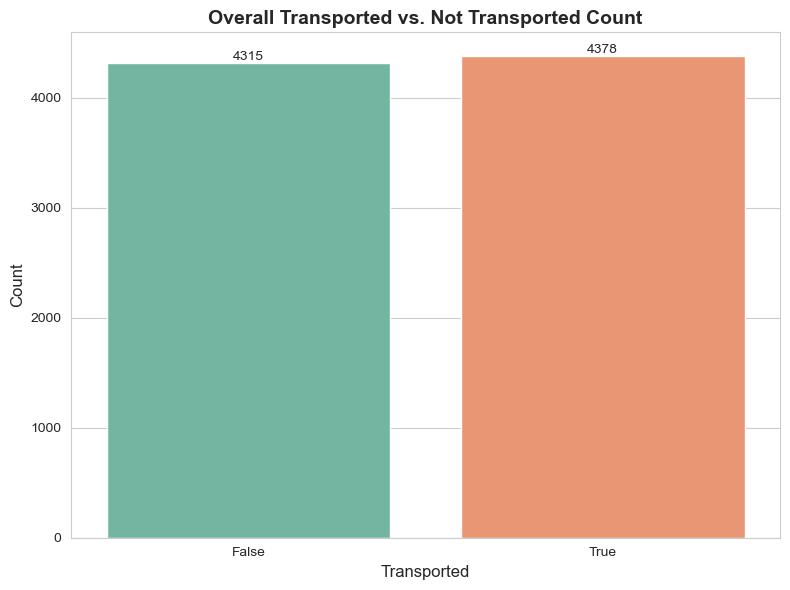

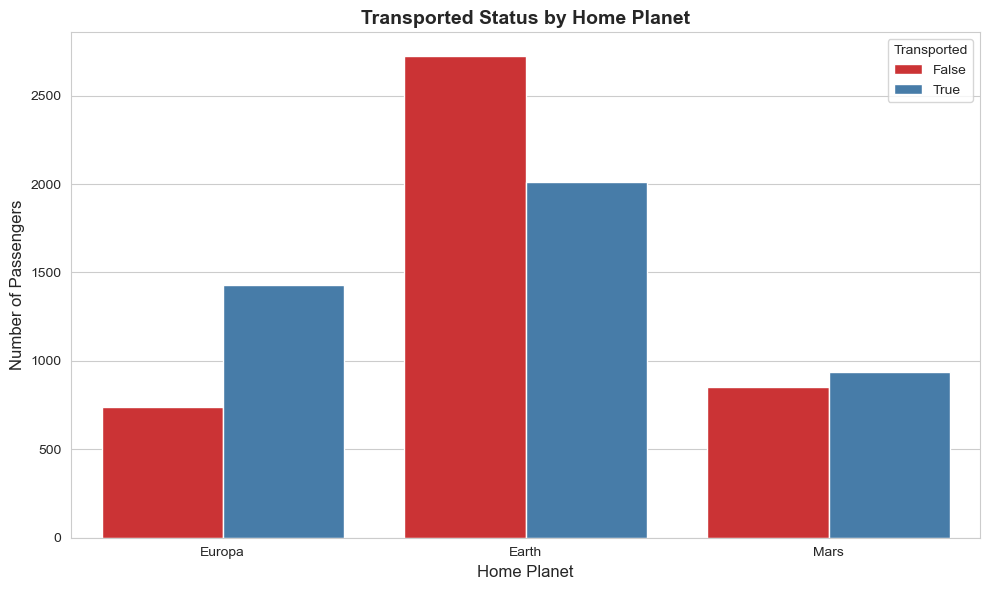

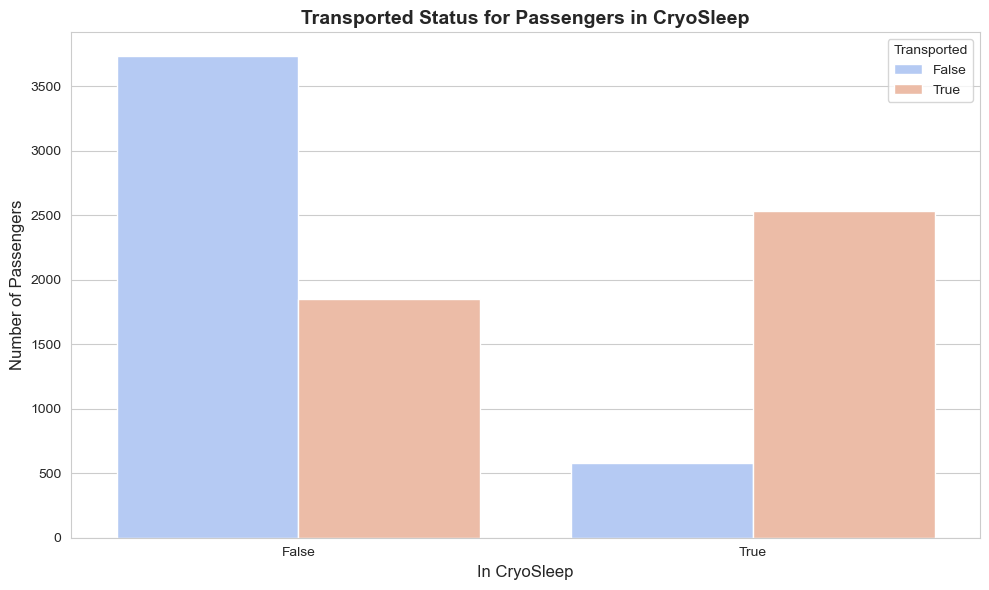

C:\Users\avani\AppData\Local\Temp\ipykernel_18880\1209564556.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Transported')


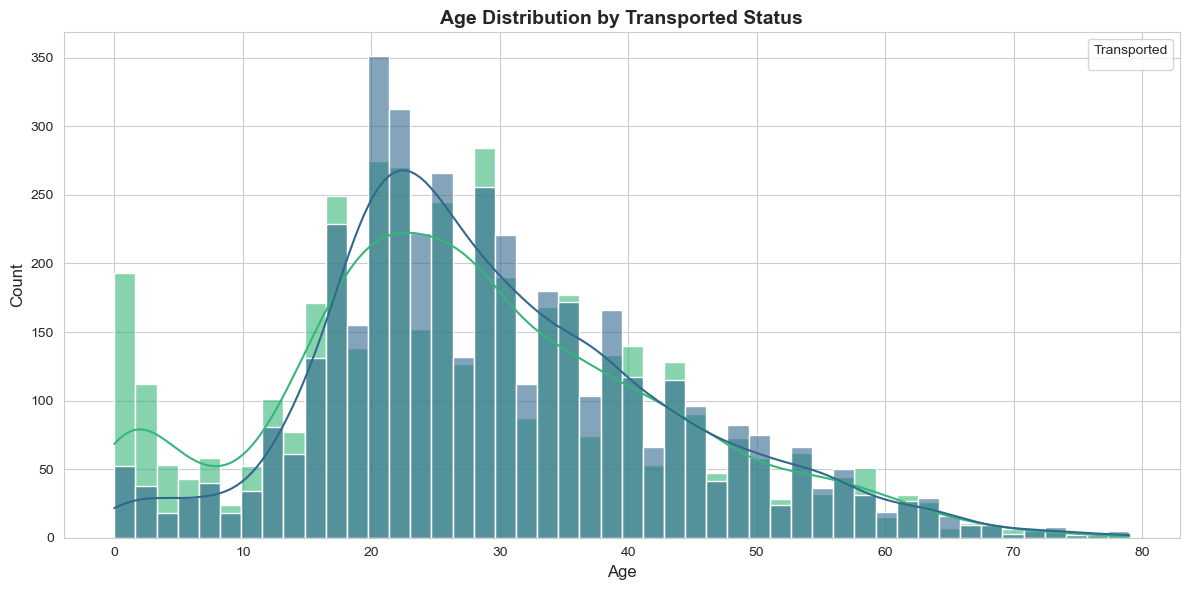

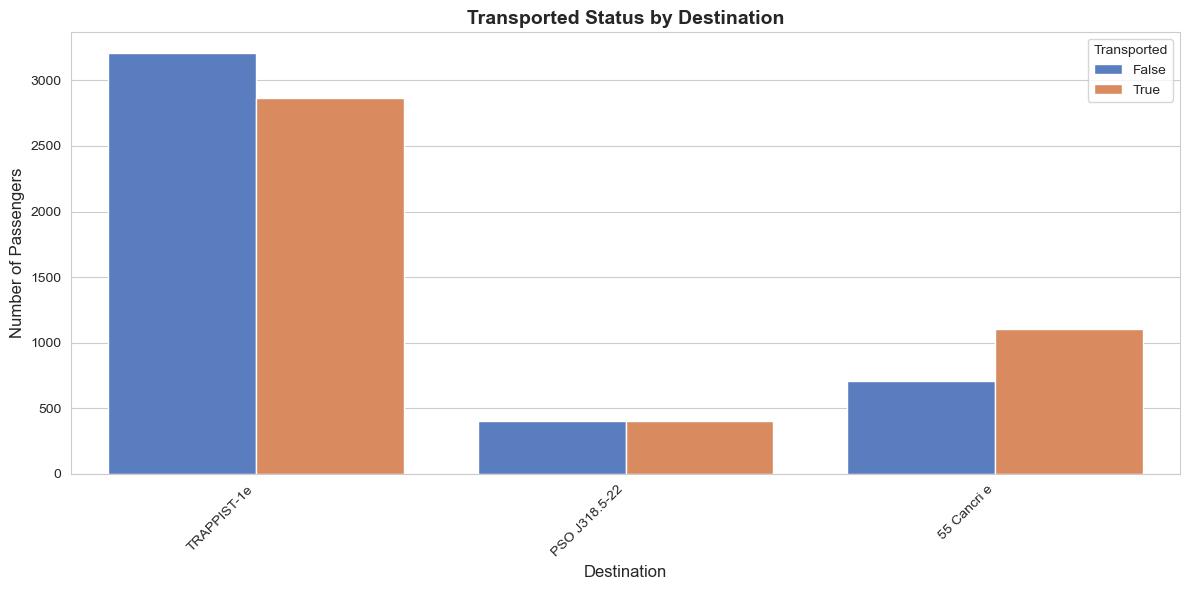

Note: 'Deck' column not found in dataset. Skipping Plot 6.


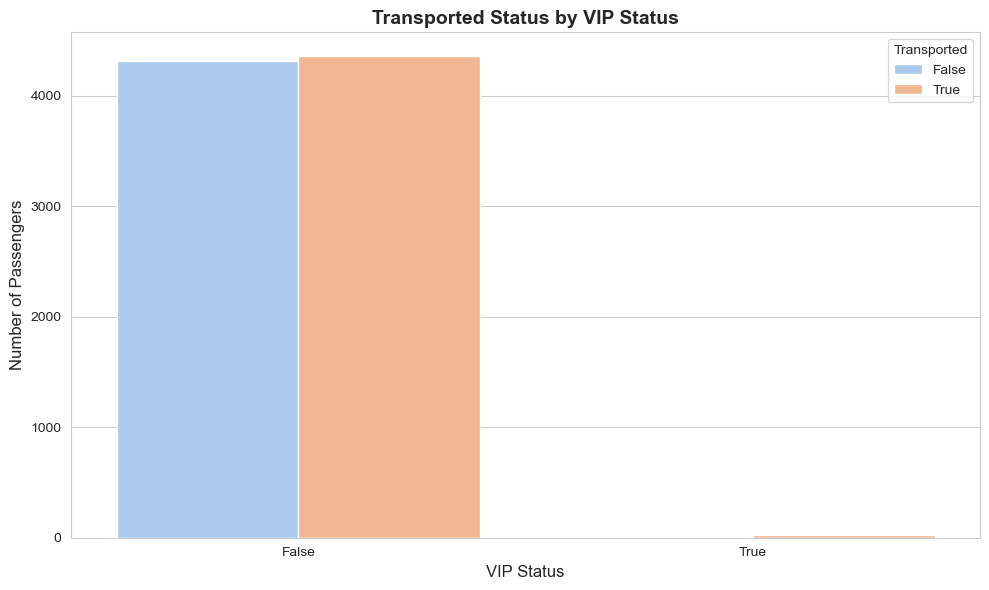

C:\Users\avani\AppData\Local\Temp\ipykernel_18880\1209564556.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_spending, x='Transported', y='TotalSpending', palette='Set3')


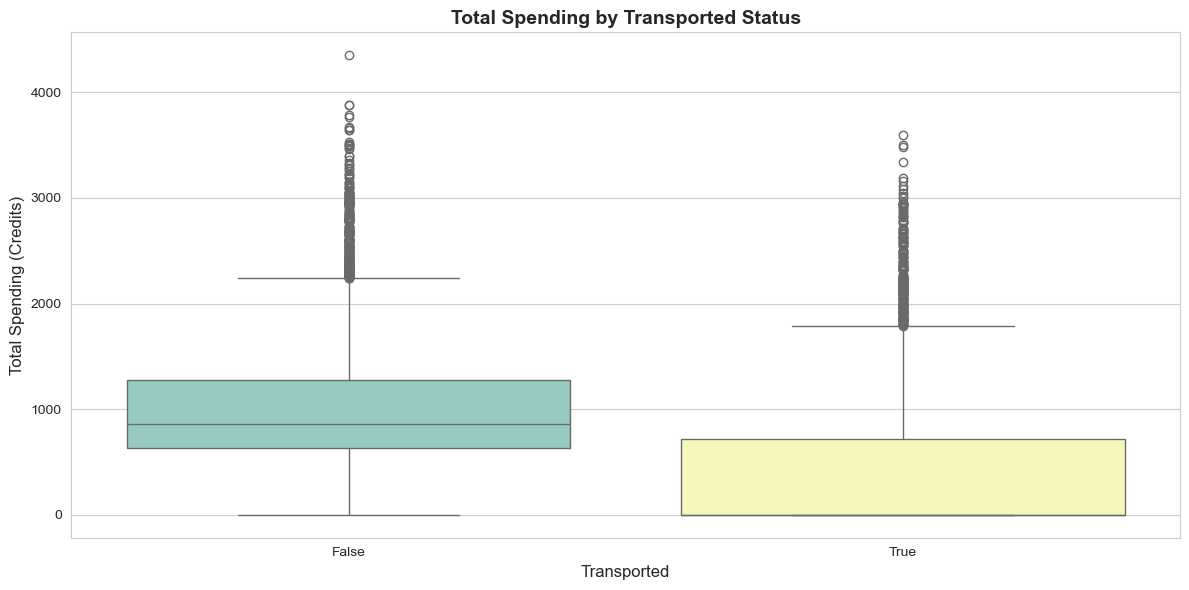

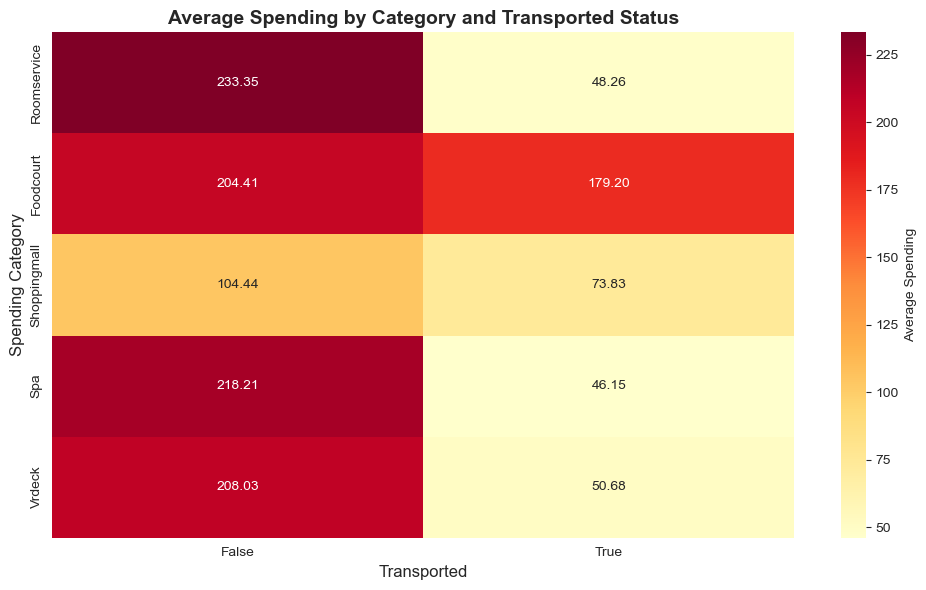

Note: 'Side' column not found. Skipping Plot 10.


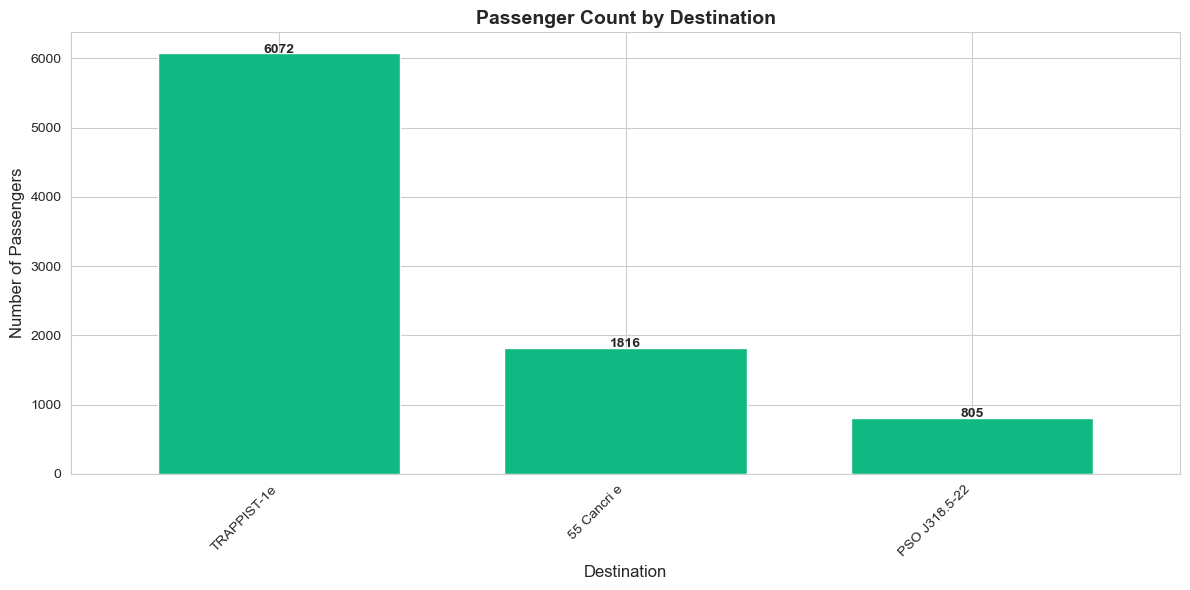

Note: 'Deck' column not found. Skipping Plot 12.


<Figure size 1400x800 with 0 Axes>

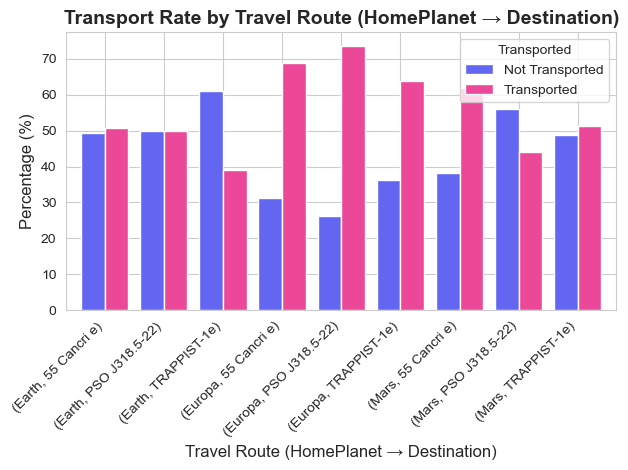

<Figure size 1200x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

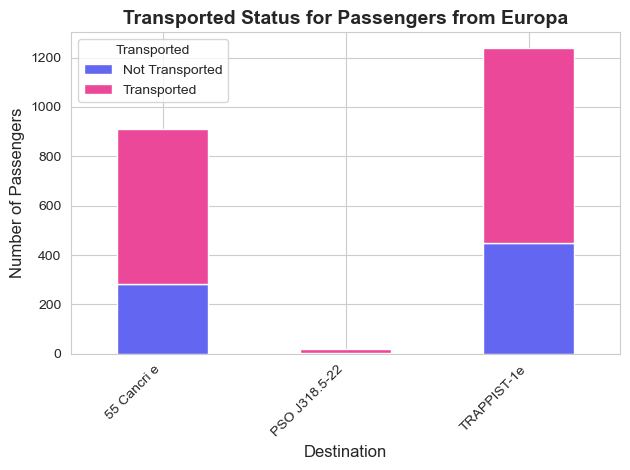

<Figure size 1000x600 with 0 Axes>

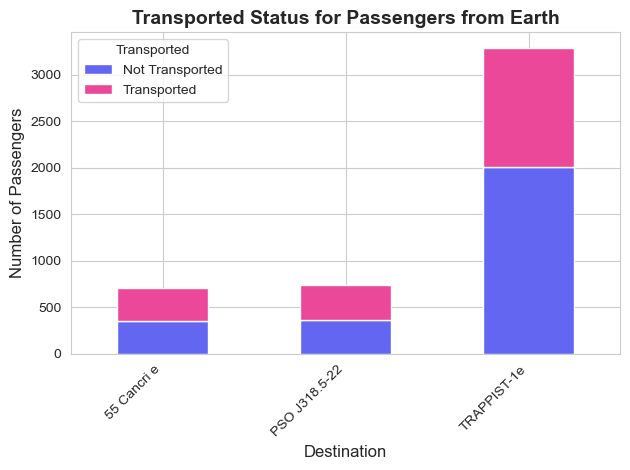

<Figure size 1000x600 with 0 Axes>

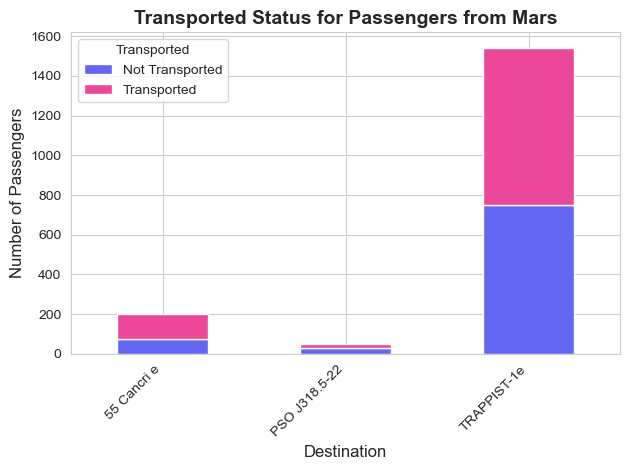


SUMMARY STATISTICS
Total Passengers: 8693
Transported: 4378 (50.4%)
Not Transported: 4315 (49.6%)

--- Home Planet Distribution ---
Homeplanet
Earth     4732
Europa    2170
Mars      1791
Name: count, dtype: int64

--- CryoSleep Distribution ---
Cryosleep
False    5580
True     3113
Name: count, dtype: int64

--- Destination Distribution ---
Destination
TRAPPIST-1e      6072
55 Cancri e      1816
PSO J318.5-22     805
Name: count, dtype: int64

--- VIP Distribution ---
Vip
False    8671
True       22
Name: count, dtype: int64

--- Age Statistics ---
count    8693.000000
mean       28.781433
std        14.355957
min         0.000000
25%        20.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64

--- Missing Values ---
Passengerid      0
Homeplanet       0
Cryosleep        0
Cabin           99
Destination      0
Age              0
Vip              0
Roomservice      0
Foodcourt        0
Shoppingmall     0
Spa              0
Vrdeck          

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# ========================================
# LOAD YOUR CLEANED DATASET
# ========================================
df = pd.read_csv('cleaned_dataset.csv')

# Quick check to see if data loaded correctly
print("=" * 50)
print("DATASET LOADED SUCCESSFULLY!")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nData types:")
print(df.dtypes)
print("=" * 50)

# ========================================
# EXPLORATORY DATA ANALYSIS - VISUALIZATIONS
# ========================================

# Plot 1: Overall Transported Status
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Transported', palette='Set2')
plt.title('Overall Transported vs. Not Transported Count', fontsize=14, fontweight='bold')
plt.xlabel('Transported', fontsize=12)
plt.ylabel('Count', fontsize=12)
for container in plt.gca().containers:
    plt.gca().bar_label(container)
plt.tight_layout()
plt.show()

# Plot 2: Transported Status by Home Planet
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Homeplanet', hue='Transported', palette='Set1')
plt.title('Transported Status by Home Planet', fontsize=14, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12)
plt.xlabel('Home Planet', fontsize=12)
plt.legend(title='Transported')
plt.tight_layout()
plt.show()
# INSIGHT: This shows if passengers from a certain planet were more likely to be transported.

# Plot 3: Transported Status by CryoSleep
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Cryosleep', hue='Transported', palette='coolwarm')
plt.title('Transported Status for Passengers in CryoSleep', fontsize=14, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12)
plt.xlabel('In CryoSleep', fontsize=12)
plt.legend(title='Transported')
plt.tight_layout()
plt.show()
# INSIGHT: Were passengers in cryosleep protected from the anomaly?

# Plot 4: Age Distribution of Passengers by Transported Status
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age', hue='Transported', kde=True, multiple="layer", alpha=0.6, palette='viridis')
plt.title('Age Distribution by Transported Status', fontsize=14, fontweight='bold')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Transported')
plt.tight_layout()
plt.show()
# INSIGHT: Did the anomaly affect certain age groups more than others?

# Plot 5: Transported Status by Destination
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Destination', hue='Transported', palette='muted')
plt.title('Transported Status by Destination', fontsize=14, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12)
plt.xlabel('Destination', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Transported')
plt.tight_layout()
plt.show()
# INSIGHT: Does the intended destination correlate with being transported?

# Plot 6: Transported Status by Cabin Deck
if 'Deck' in df.columns:
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x='Deck', hue='Transported', order=sorted(df['Deck'].unique()), palette='Spectral')
    plt.title('Transported Status by Cabin Deck', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Passengers', fontsize=12)
    plt.xlabel('Cabin Deck', fontsize=12)
    plt.legend(title='Transported')
    plt.tight_layout()
    plt.show()
    # INSIGHT: Was a specific area of the ship (Deck) more affected?
else:
    print("Note: 'Deck' column not found in dataset. Skipping Plot 6.")

# Plot 7: VIP Status vs Transported
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Vip', hue='Transported', palette='pastel')
plt.title('Transported Status by VIP Status', fontsize=14, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12)
plt.xlabel('VIP Status', fontsize=12)
plt.legend(title='Transported')
plt.tight_layout()
plt.show()
# INSIGHT: Were VIP passengers treated differently by the anomaly?

# Plot 8: Spending Patterns
spending_cols = ['Roomservice', 'Foodcourt', 'Shoppingmall', 'Spa', 'Vrdeck']
df_spending = df[spending_cols + ['Transported']].copy()
df_spending['TotalSpending'] = df_spending[spending_cols].sum(axis=1)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_spending, x='Transported', y='TotalSpending', palette='Set3')
plt.title('Total Spending by Transported Status', fontsize=14, fontweight='bold')
plt.ylabel('Total Spending (Credits)', fontsize=12)
plt.xlabel('Transported', fontsize=12)
plt.tight_layout()
plt.show()
# INSIGHT: Did spending patterns correlate with being transported?
# HOW IT WORKS: 
# - Box shows middle 50% of data (25th-75th percentile)
# - Line in box = median spending
# - Whiskers = typical range
# - Dots = outliers (unusually high/low spenders)

# Plot 9: Heatmap of Average Spending by Category
avg_spending_by_transported = df.groupby('Transported')[spending_cols].mean()
plt.figure(figsize=(10, 6))
sns.heatmap(avg_spending_by_transported.T, annot=True, fmt='.2f', cmap='YlOrRd', cbar_kws={'label': 'Average Spending'})
plt.title('Average Spending by Category and Transported Status', fontsize=14, fontweight='bold')
plt.ylabel('Spending Category', fontsize=12)
plt.xlabel('Transported', fontsize=12)
plt.tight_layout()
plt.show()
# INSIGHT: Which amenities were used more by transported vs non-transported passengers?

# Plot 10: Transported Rate by Cabin Side (P or S)
if 'Side' in df.columns:
    plt.figure(figsize=(10, 6))
    
    # Calculate transport rate by side
    side_transport = df.groupby('Side')['Transported'].agg(['sum', 'count'])
    side_transport['rate'] = (side_transport['sum'] / side_transport['count']) * 100
    
    # Create bar plot
    ax = side_transport['rate'].plot(kind='bar', color=['#3b82f6', '#ec4899'], width=0.6)
    plt.title('Transported Rate by Cabin Side (Port vs Starboard)', fontsize=14, fontweight='bold')
    plt.ylabel('Transport Rate (%)', fontsize=12)
    plt.xlabel('Cabin Side', fontsize=12)
    plt.xticks(rotation=0)
    
    # Add value labels on bars
    for i, v in enumerate(side_transport['rate']):
        ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
    
    # Add count annotations
    for i, (idx, row) in enumerate(side_transport.iterrows()):
        ax.text(i, -5, f'n={int(row["count"])}', ha='center', fontsize=10, color='gray')
    
    plt.ylim(0, max(side_transport['rate']) * 1.15)
    plt.tight_layout()
    plt.show()
    # INSIGHT: Did the side of the ship (Port/Starboard) affect transport likelihood?
else:
    print("Note: 'Side' column not found. Skipping Plot 10.")

# Plot 11: Count of Passengers per Destination
plt.figure(figsize=(12, 6))
dest_counts = df['Destination'].value_counts().sort_values(ascending=False)
ax = dest_counts.plot(kind='bar', color='#10b981', width=0.7)
plt.title('Passenger Count by Destination', fontsize=14, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12)
plt.xlabel('Destination', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, v in enumerate(dest_counts):
    ax.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
# INSIGHT: Which destinations were most popular among passengers?

# Plot 12: Heatmap of Deck vs Destination with Transport Rate
if 'Deck' in df.columns:
    plt.figure(figsize=(14, 8))
    
    # Create pivot table: Deck x Destination with Transport Rate
    deck_dest_pivot = df.groupby(['Deck', 'Destination'])['Transported'].agg(['sum', 'count'])
    deck_dest_pivot['transport_rate'] = (deck_dest_pivot['sum'] / deck_dest_pivot['count']) * 100
    
    # Reshape for heatmap
    heatmap_data = deck_dest_pivot['transport_rate'].unstack(fill_value=0)
    
    # Create heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'Transport Rate (%)'}, linewidths=0.5)
    plt.title('Transport Rate (%) by Deck and Destination', fontsize=14, fontweight='bold')
    plt.ylabel('Cabin Deck', fontsize=12)
    plt.xlabel('Destination', fontsize=12)
    plt.tight_layout()
    plt.show()
    # INSIGHT: Were certain deck-destination combinations more vulnerable?
    
    # Also show passenger counts for context
    plt.figure(figsize=(14, 8))
    count_heatmap = deck_dest_pivot['count'].unstack(fill_value=0)
    sns.heatmap(count_heatmap, annot=True, fmt='.0f', cmap='Blues', 
                cbar_kws={'label': 'Passenger Count'}, linewidths=0.5)
    plt.title('Passenger Count by Deck and Destination', fontsize=14, fontweight='bold')
    plt.ylabel('Cabin Deck', fontsize=12)
    plt.xlabel('Destination', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("Note: 'Deck' column not found. Skipping Plot 12.")

# Plot 13: Transported Status by HomePlanet --> Destination Route
plt.figure(figsize=(14, 8))

# Create a cross-tabulation
route_transport = pd.crosstab([df['Homeplanet'], df['Destination']], df['Transported'], normalize='index') * 100

# Create grouped bar chart
route_transport.plot(kind='bar', color=['#6366f1', '#ec4899'], width=0.8)
plt.title('Transport Rate by Travel Route (HomePlanet → Destination)', fontsize=14, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Travel Route (HomePlanet → Destination)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Transported', labels=['Not Transported', 'Transported'])
plt.tight_layout()
plt.show()
# INSIGHT: Were certain travel routes (origin → destination) more dangerous?

# Alternative visualization: Sankey-style count
plt.figure(figsize=(12, 8))
route_counts = df.groupby(['Homeplanet', 'Destination', 'Transported']).size().reset_index(name='count')

# Create stacked bar for each homeplanet
for homeplanet in df['Homeplanet'].unique():
    homeplanet_data = df[df['Homeplanet'] == homeplanet]
    
    # Get destination counts
    dest_transport = homeplanet_data.groupby(['Destination', 'Transported']).size().unstack(fill_value=0)
    
    plt.figure(figsize=(10, 6))
    dest_transport.plot(kind='bar', stacked=True, color=['#6366f1', '#ec4899'])
    plt.title(f'Transported Status for Passengers from {homeplanet}', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Passengers', fontsize=12)
    plt.xlabel('Destination', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Transported', labels=['Not Transported', 'Transported'])
    plt.tight_layout()
    plt.show()
# INSIGHT: Breaking down by homeplanet shows which origin-destination pairs were affected

# ========================================
# SUMMARY STATISTICS
# ========================================
print("\n" + "=" * 50)
print("SUMMARY STATISTICS")
print("=" * 50)
print(f"Total Passengers: {len(df)}")
print(f"Transported: {df['Transported'].sum()} ({df['Transported'].sum()/len(df)*100:.1f}%)")
print(f"Not Transported: {len(df) - df['Transported'].sum()} ({(len(df) - df['Transported'].sum())/len(df)*100:.1f}%)")

print(f"\n--- Home Planet Distribution ---")
print(df['Homeplanet'].value_counts())

print(f"\n--- CryoSleep Distribution ---")
print(df['Cryosleep'].value_counts())

print(f"\n--- Destination Distribution ---")
print(df['Destination'].value_counts())

print(f"\n--- VIP Distribution ---")
print(df['Vip'].value_counts())

if 'Side' in df.columns:
    print(f"\n--- Cabin Side Distribution ---")
    print(df['Side'].value_counts())

print(f"\n--- Age Statistics ---")
print(df['Age'].describe())

print(f"\n--- Missing Values ---")
print(df.isnull().sum())

print(f"\n--- Correlation with Transported Status ---")
# Only select NUMERIC and BOOLEAN columns for correlation
df_numeric = df.select_dtypes(include=['number', 'bool']).copy()

# Convert boolean columns to numeric
bool_cols = df_numeric.select_dtypes(include='bool').columns
for col in bool_cols:
    df_numeric[col] = df_numeric[col].astype(int)

# Calculate correlation with Transported (only if it exists in numeric df)
if 'Transported' in df_numeric.columns:
    correlations = df_numeric.corr()['Transported'].sort_values(ascending=False)
    print(correlations)
else:
    print("Note: Transported column not found in numeric data or needs conversion.")
    print("\nNumeric columns available:")
    print(df_numeric.columns.tolist())

print("=" * 50)
print("ANALYSIS COMPLETE!")
print("=" * 50)